## Set-up

In [33]:
from PhaseHunter.model import PhaseHunter
from PhaseHunter.dataloader import Augmentations, Waveforms_dataset

import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

import torch
from tqdm.auto import tqdm

def make_predictions_phasehunter(model, test_loader, filename):
    ## Create list to store results 
    test_results = []
    
    with torch.no_grad():
        for sample in tqdm(test_loader):
            waveform, p_true, s_true = sample
    
            ## For uncertainty estimation we need ot create a batch of copies
            inference_sample = torch.stack([waveform.squeeze()]*128).cuda()
    
            ## Make predictions
            preds, _ = model(inference_sample)
    
            p_pred = preds[:,0].cpu()
            s_pred = preds[:,1].cpu()
    
            ## Using uncertainty get prediction with the highest probability
            p_dist, p_kde, p_val, p_uncert = model.get_likely_val(p_pred)
            s_dist, s_kde, s_val, s_uncert = model.get_likely_val(s_pred)
    
            ## Store results
            test_results.append(pd.DataFrame({
                'p_true' : [p_true.item()*30],     's_true' : [s_true.item()*30],
                'p_pred' : [p_val.item()*30],      's_pred' : [s_val.item()*30],
                'p_uncert' : [p_uncert.item()*30], 's_uncert' : [s_uncert.item()*30]
            }))
    
    test_results_phasehunter = pd.concat(test_results).reset_index(drop=True)
    test_results_phasehunter.to_csv(filename)

def make_predictions_phasenet(model, test_loader, filename):
    ## Create list to store results 
    test_results = []
    
    with torch.no_grad():
        for sample in tqdm(test_loader):
            waveform, p_true, s_true = sample
    
            p_pred_prob, s_pred_prob, noise_pred_prob = phasenet(waveform).squeeze().split(1, dim=0)
    
            # Get the predicted P and S arrival times
            p_prob, p_predicted_index = torch.max(p_pred_prob, dim=1)
            s_prob, s_predicted_index = torch.max(s_pred_prob, dim=1)
    
            ## Store results
            test_results.append(pd.DataFrame({
                'p_true' : [p_true.item()*30], 's_true' : [s_true.item()*30],
                'p_pred' : [p_predicted_index.item()*0.01], 's_pred' : [s_predicted_index.item()*0.01],
                'p_prob' : [p_prob.item()], 's_prob' : [s_prob.item()]
            }))
    
    test_results_phasenet = pd.concat(test_results).reset_index(drop=True)
    test_results_phasenet.to_csv(filename)
    
def evaluate_phasehunter(predictions_eq, predictions_noise, threshold, metric_type):
    """
    Evaluate the model based on TP, FP, FN, TN values and compute metrics.
    predictions_eq: DataFrame with earthquake predictions and uncertainties.
    predictions_noise: DataFrame with noise predictions and uncertainties.
    threshold: Uncertainty threshold to classify into positive and negative classes.
    metric_type: 'mean_uncert', 'p_uncert', or 's_uncert' to decide which column to use for thresholding.
    
    Returns: A dictionary of evaluation metrics.
    """

    # Define earthquake metrics
    TP_eq = len(predictions_eq[predictions_eq[metric_type] < threshold])
    FN_eq = len(predictions_eq[predictions_eq[metric_type] >= threshold])
    
    # Define noise metrics
    FP_noise = len(predictions_noise[predictions_noise[metric_type] < threshold])
    TN_noise = len(predictions_noise[predictions_noise[metric_type] >= threshold])

    predictions_eq['p_MAE'] = np.abs(predictions_eq['p_true'] - predictions_eq['p_pred'])
    predictions_eq['s_MAE'] = np.abs(predictions_eq['s_true'] - predictions_eq['s_pred'])
    
    # MAE and RMSE for p and s
    p_MAE = predictions_eq[predictions_eq[metric_type] < threshold]['p_MAE'].mean()
    s_MAE = predictions_eq[predictions_eq[metric_type] < threshold]['s_MAE'].mean()
    p_RMSE = np.sqrt((predictions_eq[predictions_eq[metric_type] < threshold]['p_MAE'] ** 2).mean())
    s_RMSE = np.sqrt((predictions_eq[predictions_eq[metric_type] < threshold]['s_MAE'] ** 2).mean())

    # Compute metrics
    accuracy = (TP_eq + TN_noise) / (TP_eq + TN_noise + FP_noise + FN_eq)
    precision = TP_eq / (TP_eq + FP_noise) if TP_eq + FP_noise != 0 else 0
    recall = TP_eq / (TP_eq + FN_eq) if TP_eq + FN_eq != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
    specificity = TN_noise / (TN_noise + FP_noise) if TN_noise + FP_noise != 0 else 0

    return {
        "Accuracy": '%.4f' % accuracy,
        "Precision": '%.4f' % precision,
        "Recall": '%.4f' % recall,
        "F1-Score": '%.4f' % f1_score,
        "Specificity": '%.4f' % specificity,
        "p_MAE": '%.4f' % p_MAE,
        "s_MAE": '%.4f' % s_MAE,
        "p_RMSE": '%.4f' % p_RMSE,
        "s_RMSE": '%.4f' % s_RMSE
    }

def evaluate_phasenet(predictions_eq, predictions_noise, threshold, metric_type):
    """
    Evaluate the model based on TP, FP, FN, TN values and compute metrics.
    predictions_eq: DataFrame with earthquake predictions and uncertainties.
    predictions_noise: DataFrame with noise predictions and uncertainties.
    threshold: Uncertainty threshold to classify into positive and negative classes.
    metric_type: 'mean_uncert', 'p_uncert', or 's_uncert' to decide which column to use for thresholding.
    
    Returns: A dictionary of evaluation metrics.
    """

    # Define earthquake metrics
    TP_eq = len(predictions_eq[predictions_eq[metric_type] > threshold])
    FN_eq = len(predictions_eq[predictions_eq[metric_type] <= threshold])
    
    # Define noise metrics
    FP_noise = len(predictions_noise[predictions_noise[metric_type] > threshold])
    TN_noise = len(predictions_noise[predictions_noise[metric_type] <= threshold])

    predictions_eq['p_MAE'] = np.abs(predictions_eq['p_true'] - predictions_eq['p_pred'])
    predictions_eq['s_MAE'] = np.abs(predictions_eq['s_true'] - predictions_eq['s_pred'])
    
    # MAE and RMSE for p and s
    p_MAE = predictions_eq[predictions_eq[metric_type] > threshold]['p_MAE'].mean()
    s_MAE = predictions_eq[predictions_eq[metric_type] > threshold]['s_MAE'].mean()
    p_RMSE = np.sqrt((predictions_eq[predictions_eq[metric_type] > threshold]['p_MAE'] ** 2).mean())
    s_RMSE = np.sqrt((predictions_eq[predictions_eq[metric_type] > threshold]['s_MAE'] ** 2).mean())

    # Compute metrics
    accuracy = (TP_eq + TN_noise) / (TP_eq + TN_noise + FP_noise + FN_eq)
    precision = TP_eq / (TP_eq + FP_noise) if TP_eq + FP_noise != 0 else 0
    recall = TP_eq / (TP_eq + FN_eq) if TP_eq + FN_eq != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
    specificity = TN_noise / (TN_noise + FP_noise) if TN_noise + FP_noise != 0 else 0

    return {
        "Accuracy": '%.4f' % accuracy,
        "Precision": '%.4f' % precision,
        "Recall": '%.4f' % recall,
        "F1-Score": '%.4f' % f1_score,
        "Specificity": '%.4f' % specificity,
        "p_MAE": '%.4f' % p_MAE,
        "s_MAE": '%.4f' % s_MAE,
        "p_RMSE": '%.4f' % p_RMSE,
        "s_RMSE": '%.4f' % s_RMSE
    }


# STEAD

### Load data

In [6]:
df = pd.read_csv('Seisbench_DATA/stead_mem.csv')
df_noise = pd.read_csv('Seisbench_DATA/stead_mem_noise.csv')

data = np.memmap('Seisbench_DATA/stead.dat', dtype='float32', mode='r', shape=(len(df), 3, 9000))
noise = np.memmap('Seisbench_DATA/stead_noise.dat', dtype='float32', mode='r', shape=(len(df_noise), 3, 9000))

augmentations = Augmentations(padding=120, crop_length=3000)

[rank: 0] Global seed set to 42
/tmp/ipykernel_66718/584206807.py:8: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Seisbench_DATA/stead_mem.csv')


In [288]:
# Get the unique source IDs
unique_source_ids = df['source_id'].unique()

# Split unique source IDs into train, val, and test sets
train_size = int(0.8 * len(unique_source_ids))
val_size = int(0.1 * len(unique_source_ids))

test_ids = unique_source_ids[train_size + val_size:]
test_mask = df['source_id'].isin(test_ids)

df_test = df[test_mask][['trace_P_final','trace_S_final']].fillna(0)

test_dataset = Waveforms_dataset(meta=df_test, data=data, test=True, transform=True, augmentations=augmentations)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=2, batch_size=1, pin_memory=True, drop_last=True)

df_noise = df_noise.sample(n=60000, random_state=42)[['trace_P_final','trace_S_final']].fillna(0) 

noise_dataset = Waveforms_dataset(meta=df_noise, data=noise, test=True, transform=True, augmentations=augmentations)
noise_loader = DataLoader(noise_dataset, shuffle=False, num_workers=2, batch_size=1, pin_memory=True, drop_last=True)

## PhaseHunter

In [290]:
model = PhaseHunter(n_masks=128, n_outs=2).load_from_checkpoint('ckpts/30s_STEAD_decay-epoch=96.ckpt')
model = model.eval().cuda()

/scratch/users/anovosel/miniconda3/envs/phasehunter/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Make predictions

In [291]:

# make_predictions_phasehunter(model, test_loader, filename='PhaseHunter_STEAD_test_ckpt1.csv')
make_predictions_phasehunter(model, noise_loader, filename='PhaseHunter_STEAD_noise_ckpt1.csv')

  0%|          | 0/60000 [00:00<?, ?it/s]

### Evaluate

In [292]:
test_results_phasehunter_eqs = pd.read_csv('PhaseHunter_STEAD_test_ckpt1.csv')
test_results_phasehunter_noise = pd.read_csv('PhaseHunter_STEAD_noise_ckpt1.csv')

test_results_phasehunter_eqs = test_results_phasehunter_eqs[(test_results_phasehunter_eqs['s_true'] != 0)]

In [330]:
threshold_uncert = 0.0827

test_results_phasehunter_eqs['mean_uncert'] = (test_results_phasehunter_eqs['p_uncert'] + test_results_phasehunter_eqs['s_uncert'])/2
test_results_phasehunter_noise['mean_uncert'] = (test_results_phasehunter_noise['p_uncert'] + test_results_phasehunter_noise['s_uncert'])/2

# Sample Usage:
metrics_mean = evaluate_phasehunter(test_results_phasehunter_eqs, test_results_phasehunter_noise, threshold_uncert, 'mean_uncert')
metrics_p = evaluate_phasehunter(test_results_phasehunter_eqs, test_results_phasehunter_noise, threshold_uncert, 'p_uncert')
metrics_s = evaluate_phasehunter(test_results_phasehunter_eqs, test_results_phasehunter_noise, threshold_uncert, 's_uncert')

print('PhaseHunter')
print("Metrics using mean_uncert:", metrics_mean)
print("Metrics using p_uncert:", metrics_p)
print("Metrics using s_uncert:", metrics_s)

PhaseHunter
Metrics using mean_uncert: {'Accuracy': '0.9674', 'Precision': '0.9958', 'Recall': '0.9386', 'F1-Score': '0.9663', 'Specificity': '0.9961', 'p_MAE': '0.0452', 's_MAE': '0.0884', 'p_RMSE': '0.1011', 's_RMSE': '0.1551'}
Metrics using p_uncert: {'Accuracy': '0.9678', 'Precision': '0.9677', 'Recall': '0.9678', 'F1-Score': '0.9677', 'Specificity': '0.9679', 'p_MAE': '0.0460', 's_MAE': '0.1048', 'p_RMSE': '0.1024', 's_RMSE': '0.2847'}
Metrics using s_uncert: {'Accuracy': '0.9521', 'Precision': '0.9879', 'Recall': '0.9151', 'F1-Score': '0.9501', 'Specificity': '0.9889', 'p_MAE': '0.0480', 's_MAE': '0.0834', 'p_RMSE': '0.1265', 's_RMSE': '0.1547'}


### Evaluate Uncertainty

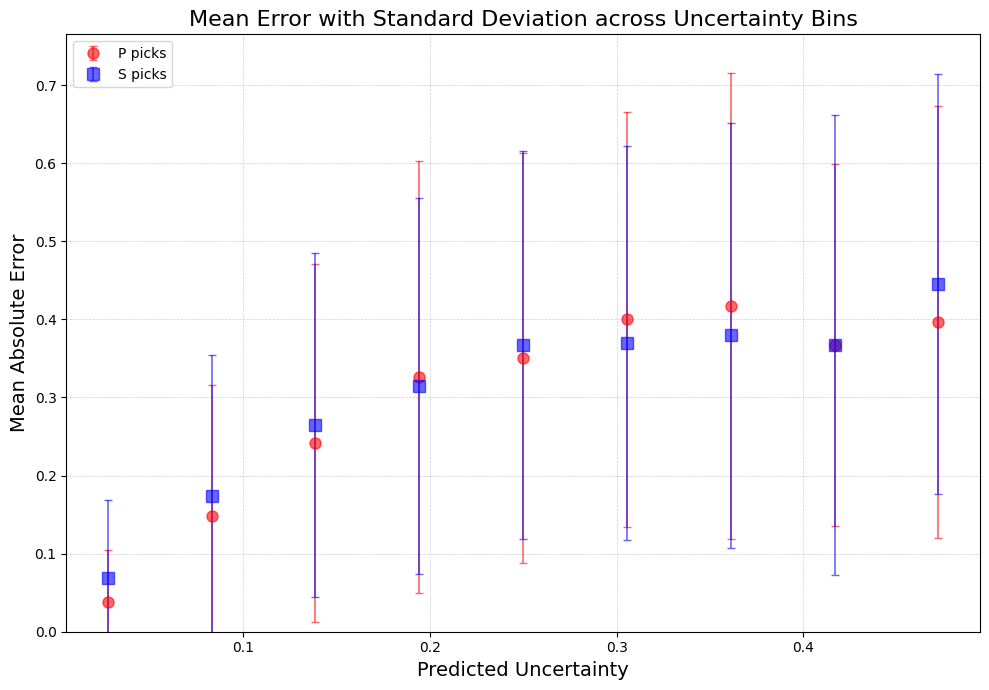

In [462]:
import numpy as np
import seaborn as sns

test_filt = test_results_phasehunter_eqs[(test_results_phasehunter_eqs.p_MAE <= 1) & (test_results_phasehunter_eqs.s_MAE <= 1)]

# Computing mean and standard deviation for each bin
bins = np.linspace(0, 0.5, 10)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

p_bin_means = np.array([test_filt["p_MAE"][np.logical_and(test_filt["p_uncert"] > left, test_filt["p_uncert"] <= right)].mean() for left, right in zip(bins[:-1], bins[1:])])
p_bin_std = np.array([test_filt["p_MAE"][np.logical_and(test_filt["p_uncert"] > left, test_filt["p_uncert"] <= right)].std() for left, right in zip(bins[:-1], bins[1:])])

s_bin_means = np.array([test_filt["s_MAE"][np.logical_and(test_filt["s_uncert"] > left, test_filt["s_uncert"] <= right)].mean() for left, right in zip(bins[:-1], bins[1:])])
s_bin_std = np.array([test_filt["s_MAE"][np.logical_and(test_filt["s_uncert"] > left, test_filt["s_uncert"] <= right)].std() for left, right in zip(bins[:-1], bins[1:])])

plt.figure(figsize=(10, 7))  # Increase plot size for better visualization
plt.errorbar(bin_centers, p_bin_means, yerr=p_bin_std, fmt='o', markersize=8, capsize=3, capthick=1, elinewidth=1.2, color='red', alpha=0.6, label='P picks')
plt.errorbar(bin_centers, s_bin_means, yerr=s_bin_std, fmt='s', markersize=8, capsize=3, capthick=1, elinewidth=1.2, color='blue', alpha=0.6, label='S picks')
plt.xlabel('Predicted Uncertainty', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Mean Error with Standard Deviation across Uncertainty Bins', fontsize=16)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(loc='upper left')  # Adjust location as needed
plt.ylim([0, max(max(p_bin_means + p_bin_std), max(s_bin_means + s_bin_std)) + 0.05])  # Adjust Y-axis limits
plt.tight_layout()  # Ensure no parts of the graph are cut off
plt.savefig('Calibration_plot.pdf')

## PhaseNet

### Make predictions

In [297]:
import seisbench.models as sbm

phasenet = sbm.PhaseNet()
phasenet = phasenet.from_pretrained('stead')
phasenet.eval()  # Set model to evaluation mode

# make_predictions_phasenet(phasenet, test_loader, filename='PhaseNET_STEAD_test_seisbench.csv')
make_predictions_phasenet(phasenet, noise_loader, filename='PhaseNET_STEAD_noise_seisbench.csv')

  0%|          | 0/60000 [00:00<?, ?it/s]

### Evaluate

In [298]:
test_results_phasenet_eqs = pd.read_csv('PhaseNET_STEAD_test_seisbench.csv')
test_results_phasenet_noise = pd.read_csv('PhaseNET_STEAD_noise_seisbench.csv')

test_results_phasenet_eqs = test_results_phasenet_eqs[(test_results_phasenet_eqs['s_true'] != 0)]

In [303]:
threshold_prob = 0.5

test_results_phasenet_eqs['mean_prob'] = (test_results_phasenet_eqs['p_prob']+test_results_phasenet_eqs['s_prob'])/2
test_results_phasenet_noise['mean_prob'] = (test_results_phasenet_noise['p_prob']+test_results_phasenet_noise['s_prob'])/2

metrics_mean = evaluate_phasenet(test_results_phasenet_eqs, test_results_phasenet_noise, threshold_prob, 'mean_prob')
metrics_p = evaluate_phasenet(test_results_phasenet_eqs, test_results_phasenet_noise, threshold_prob, 'p_prob')
metrics_s = evaluate_phasenet(test_results_phasenet_eqs, test_results_phasenet_noise, threshold_prob, 's_prob')

print('PhaseNet')
print("Metrics using mean_prob:", metrics_mean)
print("Metrics using p_prob:", metrics_p)
print("Metrics using s_prob:", metrics_s)

PhaseNet
Metrics using mean_prob: {'Accuracy': '0.9808', 'Precision': '0.9866', 'Recall': '0.9747', 'F1-Score': '0.9806', 'Specificity': '0.9869', 'p_MAE': '0.1741', 's_MAE': '0.1131', 'p_RMSE': '0.4707', 's_RMSE': '0.3528'}
Metrics using p_prob: {'Accuracy': '0.9646', 'Precision': '0.9643', 'Recall': '0.9647', 'F1-Score': '0.9645', 'Specificity': '0.9645', 'p_MAE': '0.1584', 's_MAE': '0.1604', 'p_RMSE': '0.4000', 's_RMSE': '0.9677'}
Metrics using s_prob: {'Accuracy': '0.9734', 'Precision': '0.9835', 'Recall': '0.9627', 'F1-Score': '0.9730', 'Specificity': '0.9839', 'p_MAE': '0.1836', 's_MAE': '0.1055', 'p_RMSE': '0.5219', 's_RMSE': '0.3174'}


# ETHZ

In [8]:
df = pd.read_csv('Seisbench_DATA/ethz_mem.csv')#[['trace_P_final','trace_S_final']].fillna(0)
data = np.memmap('Seisbench_DATA/ethz.dat', dtype='float32', mode='r', shape=(len(df), 3, 6000))

augmentations = Augmentations(padding=120, crop_length=3000)

# Get the unique source IDs
unique_source_ids = df['source_id'].unique()

# Split unique source IDs into train, val, and test sets
train_size = int(0.8 * len(unique_source_ids))
val_size = int(0.1 * len(unique_source_ids))

test_ids = unique_source_ids[train_size + val_size:]
unique_source_ids_train_val = unique_source_ids[:train_size + val_size]

# Shuffle the unique source IDs
np.random.shuffle(unique_source_ids_train_val)

test_mask = df['source_id'].isin(test_ids)
df_test = df[test_mask]#[['trace_P_final','trace_S_final']].fillna(0)

test_dataset = Waveforms_dataset(meta=df_test, data=data, test=True, transform=True, augmentations=augmentations)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=2, batch_size=1, pin_memory=True, drop_last=True)


### PhaseHunter

In [9]:
from PhaseHunter.model import PhaseHunter
from PhaseHunter.dataloader import Augmentations, Waveforms_dataset

model = PhaseHunter(n_masks=128, n_outs=2).load_from_checkpoint('ckpts/30s_ETHZ_decay-epoch=187-v1.ckpt')
model = model.eval().cuda()

/scratch/users/anovosel/miniconda3/envs/phasehunter/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
make_predictions_phasehunter(model, test_loader, filename='PhaseHunter_ETHZ_test.csv')

  0%|          | 0/2139 [00:00<?, ?it/s]

In [16]:
test_results_phasehunter_eqs = pd.read_csv('PhaseHunter_ETHZ_test.csv')
test_results_phasehunter_noise  = pd.DataFrame(columns=test_results_phasehunter_eqs.columns)

test_results_phasehunter_eqs = test_results_phasehunter_eqs[(test_results_phasehunter_eqs['s_true'] != 0)]

In [27]:
threshold_uncert = 0.1

test_results_phasehunter_eqs['mean_uncert'] = (test_results_phasehunter_eqs['p_uncert'] + test_results_phasehunter_eqs['s_uncert'])/2
test_results_phasehunter_noise['mean_uncert'] = (test_results_phasehunter_noise['p_uncert'] + test_results_phasehunter_noise['s_uncert'])/2

# Sample Usage:
metrics_mean = evaluate_phasehunter(test_results_phasehunter_eqs, test_results_phasehunter_noise, threshold_uncert, 'mean_uncert')
metrics_p = evaluate_phasehunter(test_results_phasehunter_eqs, test_results_phasehunter_noise, threshold_uncert, 'p_uncert')
metrics_s = evaluate_phasehunter(test_results_phasehunter_eqs, test_results_phasehunter_noise, threshold_uncert, 's_uncert')

print('PhaseHunter')
print("Metrics using mean_uncert:", metrics_mean)

PhaseHunter
Metrics using mean_uncert: {'Accuracy': '0.9711', 'Precision': '1.0000', 'Recall': '0.9711', 'F1-Score': '0.9853', 'Specificity': '0.0000', 'p_MAE': '0.0248', 's_MAE': '0.0477', 'p_RMSE': '0.0561', 's_RMSE': '0.0934'}


### PhaseNet

In [32]:
import seisbench.models as sbm

phasenet = sbm.PhaseNet()
phasenet = phasenet.from_pretrained('ethz')
phasenet.eval()  # Set model to evaluation mode

make_predictions_phasenet(phasenet, test_loader, filename='PhaseNET_ETHZ_test.csv')

  0%|          | 0/2139 [00:00<?, ?it/s]

In [34]:
test_results_phasenet_eqs = pd.read_csv('PhaseNET_ETHZ_test.csv')
test_results_phasenet_noise = pd.DataFrame(columns=test_results_phasenet_eqs.columns)

test_results_phasenet_eqs = test_results_phasenet_eqs[(test_results_phasenet_eqs['s_true'] != 0)]

In [35]:
threshold_prob = 0.5

test_results_phasenet_eqs['mean_prob'] = (test_results_phasenet_eqs['p_prob']+test_results_phasenet_eqs['s_prob'])/2
test_results_phasenet_noise['mean_prob'] = (test_results_phasenet_noise['p_prob']+test_results_phasenet_noise['s_prob'])/2

metrics_mean = evaluate_phasenet(test_results_phasenet_eqs, test_results_phasenet_noise, threshold_prob, 'mean_prob')
metrics_p = evaluate_phasenet(test_results_phasenet_eqs, test_results_phasenet_noise, threshold_prob, 'p_prob')
metrics_s = evaluate_phasenet(test_results_phasenet_eqs, test_results_phasenet_noise, threshold_prob, 's_prob')

print('PhaseNet')
print("Metrics using mean_prob:", metrics_mean)
print("Metrics using p_prob:", metrics_p)
print("Metrics using s_prob:", metrics_s)

PhaseNet
Metrics using mean_prob: {'Accuracy': '0.9353', 'Precision': '1.0000', 'Recall': '0.9353', 'F1-Score': '0.9665', 'Specificity': '0.0000', 'p_MAE': '0.0874', 's_MAE': '0.0634', 'p_RMSE': '0.1965', 's_RMSE': '0.1046'}
Metrics using p_prob: {'Accuracy': '0.9573', 'Precision': '1.0000', 'Recall': '0.9573', 'F1-Score': '0.9782', 'Specificity': '0.0000', 'p_MAE': '0.0967', 's_MAE': '0.1196', 'p_RMSE': '0.2176', 's_RMSE': '0.6747'}
Metrics using s_prob: {'Accuracy': '0.8402', 'Precision': '1.0000', 'Recall': '0.8402', 'F1-Score': '0.9132', 'Specificity': '0.0000', 'p_MAE': '0.0913', 's_MAE': '0.0553', 'p_RMSE': '0.2307', 's_RMSE': '0.0758'}
